# **Lab 4** - Exploration of Different Diff Algorithms on Open-Source Repositories

**CS202 - Software Tool and Techniques for CSE**

Bhavya Parmar

Roll no. 23110059





In [ ]:
!pip install pydriller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
from datetime import datetime, timedelta
from pydriller import Repository
import pandas as pd
import matplotlib.pyplot as plt
import os, csv

This code snippet clones and analyzes three GitHub repositories (**Gradio, FastMCP, and Aider**) using PyDriller. For each repository, it iterates through commits year by year to avoid memory overload. In two passes, it first extracts **Myers diffs** and then **Histogram diffs** for every modified file in each commit. The results are combined, and a new column called **“discrepancy”** is added, which is marked *Yes* if the two diff algorithms produce different outputs and *No* otherwise. Finally, all collected data (repo info, commit details, both diffs, and discrepancies) are written incrementally into a CSV file for later analysis.


In [ ]:
repo_urls = [
    "https://github.com/gradio-app/gradio.git",
    "https://github.com/jlowin/fastmcp.git",
    "https://github.com/Aider-AI/aider.git"
]

output_csv = "diff_dataset.csv"

# Create CSV with header
with open(output_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow([
        "repo", "old_file_path", "new_file_path", "commit_sha", "parent_sha",
        "commit_msg", "diff_myers", "diff_hist", "discrepancy"
    ])

for url in repo_urls:
    repo_name = url.split("/")[-1].replace(".git","")

    # Get first and last commit dates
    first_commit = min(c.committer_date for c in Repository(url).traverse_commits())
    last_commit = max(c.committer_date for c in Repository(url).traverse_commits())

    year = first_commit.year
    while year <= last_commit.year:
        since = datetime(year, 1, 1)
        to = datetime(year + 1, 1, 1) if year < last_commit.year else last_commit + timedelta(days=1)

        print(f"Processing {repo_name}, commits from {since.year}...")

        # First pass: Myers diffs
        myers_diffs = {}
        for commit in Repository(url, since=since, to=to, histogram_diff=False, skip_whitespaces=True).traverse_commits():
            for file in commit.modified_files:
                for parent in commit.parents:
                    key = (repo_name, commit.hash, parent, file.new_path or file.old_path)
                    myers_diffs[key] = {
                        "repo": repo_name,
                        "old_file_path": file.old_path,
                        "new_file_path": file.new_path,
                        "commit_sha": commit.hash,
                        "parent_sha": parent,
                        "commit_msg": commit.msg.strip(),
                        "diff_myers": file.diff,
                        "diff_hist": ""  # placeholder
                    }

        # Second pass: Histogram diffs
        for commit in Repository(url, since=since, to=to, histogram_diff=True, skip_whitespaces=True).traverse_commits():
            for file in commit.modified_files:
                for parent in commit.parents:
                    key = (repo_name, commit.hash, parent, file.new_path or file.old_path)
                    if key in myers_diffs:
                        myers_diffs[key]["diff_hist"] = file.diff

        # Write combined results for this year
        with open(output_csv, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            for row in myers_diffs.values():
                discrepancy = "Yes" if row["diff_myers"] != row["diff_hist"] else "No"
                writer.writerow([
                    row["repo"],
                    row["old_file_path"],
                    row["new_file_path"],
                    row["commit_sha"],
                    row["parent_sha"],
                    row["commit_msg"],
                    row["diff_myers"],
                    row["diff_hist"],
                    discrepancy
                ])

        year += 1

print(f"All results written to {output_csv}")

Processing gradio, commits from 2018...
Processing gradio, commits from 2019...
Processing gradio, commits from 2020...
Processing gradio, commits from 2021...
Processing gradio, commits from 2022...
Processing gradio, commits from 2023...
Processing gradio, commits from 2024...
Processing gradio, commits from 2025...
Processing fastmcp, commits from 2024...
Processing fastmcp, commits from 2025...
Processing aider, commits from 2023...
Processing aider, commits from 2024...
Processing aider, commits from 2025...
All results written to diff_dataset.csv


The code below processes the large CSV file in **chunks** to avoid memory crashes and focuses only on rows where a **discrepancy** was found between Myers and Histogram diffs. For each mismatched file, it identifies the repository and classifies the file type into four categories: **source code** (.py, .java, .c, .cpp), **test files**, **README**, or **LICENSE**. It then counts mismatches per category for each repository and stores the results in a dictionary. In the end, it prints out a clear, repository-wise breakdown of where the diff algorithms disagreed the most.


In [ ]:
stats_repo = {}

chunksize = 10000  # Process CSV file in chunks to avoid crashing
i = 1

for chunk in pd.read_csv(output_csv, chunksize=chunksize):
    print(f"Processing chunk {i}...")
    i += 1
    mismatches = chunk[chunk["discrepancy"] == "Yes"]

    for _, row in mismatches.iterrows():
        fname = (str(row.get("new_file_path") or row.get("old_file_path") or "")).lower()
        repo = row.get("repo")

        if repo not in stats_repo:
            stats_repo[repo] = {"source": 0, "test": 0, "readme": 0, "license": 0}

        if fname.endswith((".py", ".java", ".c", ".cpp")):
            stats_repo[repo]["source"] += 1
        elif "test" in fname:
            stats_repo[repo]["test"] += 1
        elif "readme" in fname:
            stats_repo[repo]["readme"] += 1
        elif "license" in fname:
            stats_repo[repo]["license"] += 1

print("Repository-wise mismatch stats:", stats_repo)

Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Repository-wise mismatch stats: {'gradio': {'source': 435, 'test': 41, 'readme': 30, 'license': 2}, 'fastmcp': {'source': 158, 'test': 1, 'readme': 10, 'license': 2}, 'aider': {'source': 247, 'test': 2, 'readme': 12, 'license': 0}}


Below is the visualization for the statistics obtained above

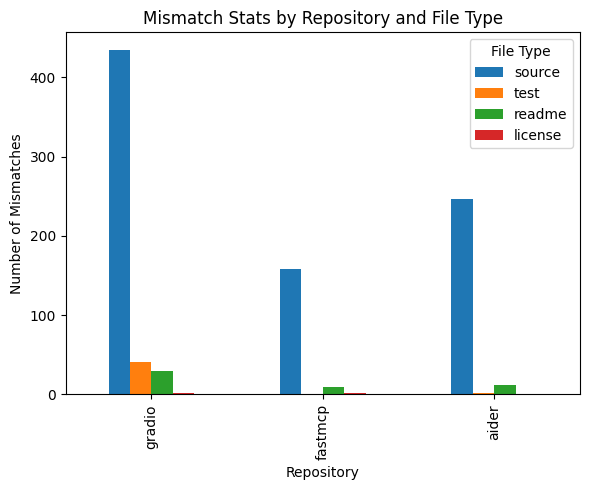

In [ ]:
# Convert to DataFrame for plotting
df = pd.DataFrame(stats_repo).T  # repos as rows, categories as columns

df.plot(kind="bar", figsize=(6,5))
plt.title("Mismatch Stats by Repository and File Type")
plt.xlabel("Repository")
plt.ylabel("Number of Mismatches")
plt.legend(title="File Type")
plt.tight_layout()
plt.show()

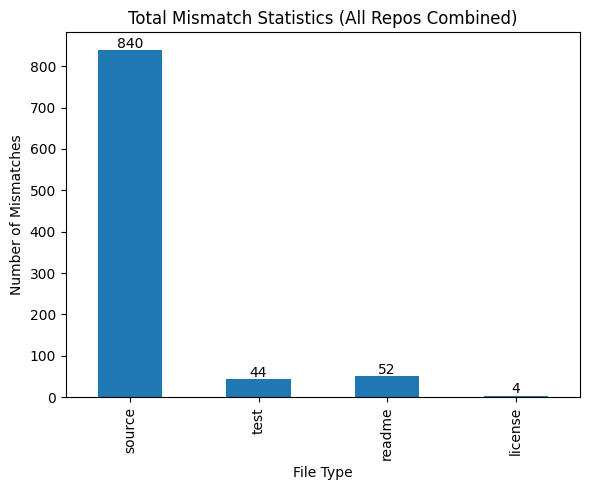

In [ ]:
totals = df.sum()
totals.plot(kind="bar", figsize=(6,5))
plt.title("Total Mismatch Statistics (All Repos Combined)")
plt.xlabel("File Type")
plt.ylabel("Number of Mismatches")
for i, v in enumerate(totals):
    plt.text(i, v+5, str(v), ha='center')
plt.tight_layout()
plt.show()

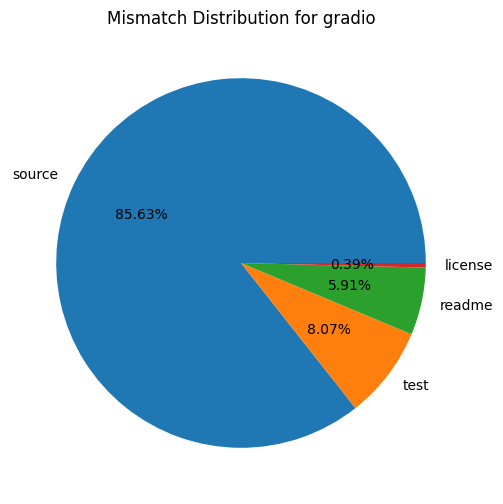

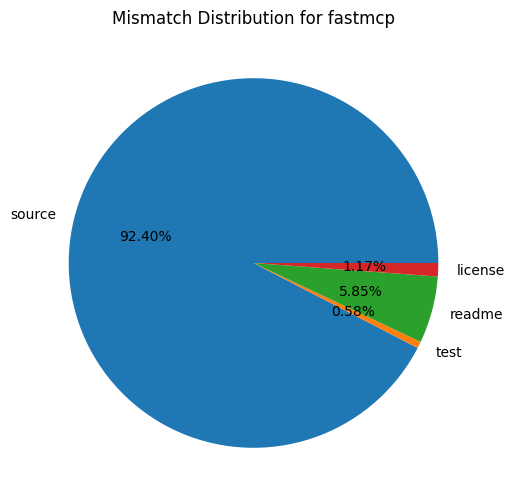

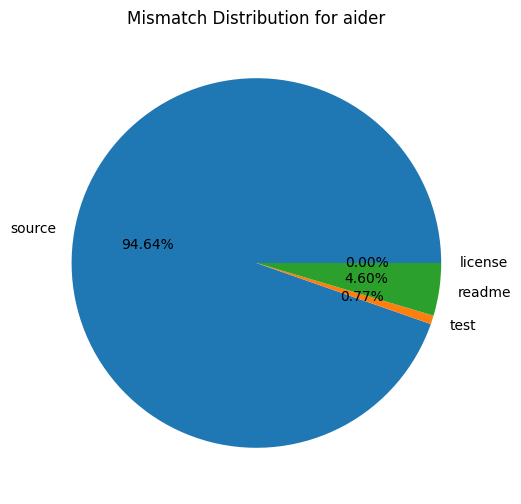

In [ ]:
for repo, counts in stats_repo.items():
    plt.figure(figsize=(6,6))
    plt.pie(counts.values(), labels=counts.keys(), autopct='%1.2f%%')
    plt.title(f"Mismatch Distribution for {repo}")
    plt.show()

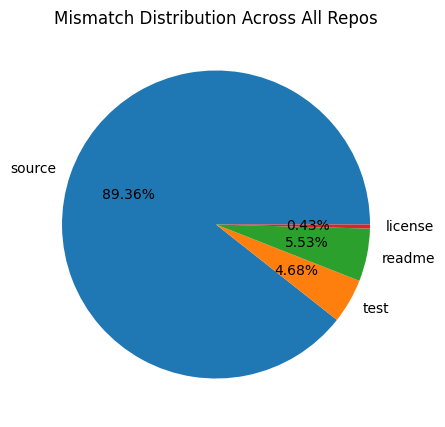

In [ ]:
plt.figure(figsize=(5,5))
plt.pie(totals.values, labels=totals.index, autopct='%1.2f%%')
plt.title("Mismatch Distribution Across All Repos")
plt.show()